In [1]:
import pandas as pd

In [2]:
import pandas as pd
import spotipy

In [3]:
## Spotify secrets

In [4]:
from dotenv import load_dotenv
import os
load_dotenv()
# did this work? commenting out so secrets are safe
# print(os.getenv('SPOTIFY_CLIENT_ID'))
# print(os.getenv('SPOTIFY_CLIENT_SECRET'))

True

In [5]:
client_id  = os.getenv('SPOTIFY_CLIENT_ID')
client_secret  = os.getenv('SPOTIFY_CLIENT_SECRET')

In [6]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

auth_manager = SpotifyClientCredentials(client_id,client_secret)
spotify = spotipy.Spotify(auth_manager = auth_manager)

In [7]:
## Full 2021 dataset of audio features


In [8]:
with open('../spotifyids21.txt') as f:
    links = f.readlines()

In [9]:
#let's chunk it into 100s at a time due to Spotify API limitation
def chunks_gen(list,n):
    for i in range(0, len(list), n):
        yield list[i:i+n]

In [10]:
chunks = list(chunks_gen(links,100))

for i in range(len(chunks)):
    chunks[i] = [x.replace('\n','') for x in chunks[i]]

In [17]:
af = pd.concat([pd.DataFrame([x for x in spotify.audio_features(tracks=chunks[i]) if x is not None]) 
                for i in range(0,len(chunks))],ignore_index=True).drop_duplicates() #have to drop duplicates since this is a weekly chart

In [18]:
af.columns.tolist()

['danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'type',
 'id',
 'uri',
 'track_href',
 'analysis_url',
 'duration_ms',
 'time_signature']

In [19]:
af[af.speechiness == af.speechiness.max()] 
#anything above a 0.66 is considered to be a podcast or some sort of speaking rather than music so this seems right

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
1197,0.582,0.537,0,-9.229,1,0.619,0.129,0.0,0.0749,0.771,82.103,audio_features,0nqhKXDjsyBMvbeWmgijD0,spotify:track:0nqhKXDjsyBMvbeWmgijD0,https://api.spotify.com/v1/tracks/0nqhKXDjsyBM...,https://api.spotify.com/v1/audio-analysis/0nqh...,180930,4


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000187B19F7A30>]],
      dtype=object)

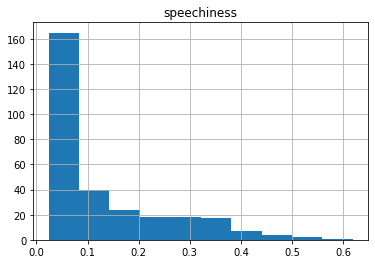

In [20]:
# af.speechiness.mean()
af.hist(column='speechiness')

In [7]:
# from pandas_profiling import ProfileReport

# profile = ProfileReport(af)
# profile

In [8]:
af[af.loudness == af.loudness.min()] 
#okay so 0 is the loudest and -60 is quietest

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
972,0.213,0.0743,9,-18.071,0,0.0408,0.344,0.000034,0.212,0.145,53.863,audio_features,416MsJxvxSKY96DCmbJIRs,spotify:track:416MsJxvxSKY96DCmbJIRs,https://api.spotify.com/v1/tracks/416MsJxvxSKY...,https://api.spotify.com/v1/audio-analysis/416M...,218507,4


### Vibe
        what's our vibe? a bop, upbeat, lots of bass, with some rap? (danceability, energy/tempo, loudness, speechiness)
tutorial here: https://www.python-graph-gallery.com/390-basic-radar-chart

In [21]:
#set up dataframe for radar chart
rdf = af.get(['danceability', 'energy', 'speechiness', 'tempo', 'loudness'])

In [22]:
# y axes need to be somewhat normalized
rdf.min(axis=0)
# rdf.max(axis=0)

danceability     0.2010
energy           0.2030
speechiness      0.0236
tempo           64.8250
loudness       -14.6190
dtype: float64

In [23]:
from sklearn.preprocessing import MinMaxScaler
# scales each feature to fit a 0-1 scale
data = (rdf.get(['tempo','loudness','speechiness']))
scaler = MinMaxScaler(clip=False)
print(scaler.fit(data))

MinMaxScaler()


In [24]:
print(scaler.data_max_)

[203.903  -2.491   0.619]


In [25]:
scaledy = pd.DataFrame(scaler.transform(data).tolist())

In [26]:
rdf = pd.concat([scaledy,rdf],axis=1,join='outer').drop(['tempo','loudness','speechiness'],axis=1).rename({0:'tempo',1:'loudness',2:'speechiness'},axis=1)

### Trying radar chart with plotly instead

In [34]:
import plotly.express as px
categories = list(rdf)
mean = rdf.mean()

In [49]:
import plotly.graph_objects as go

fig = go.Figure()


fig.add_trace(go.Scatterpolar(
  r=mean,
  theta=categories,
  fill='toself'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
        range=[0,1]
    ),
  ),
  showlegend=False
)

fig.show()

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

In [41]:
# number of variables
categories = list(rdf)
N = len(categories)

In [42]:
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
values=rdf.loc[0].values.flatten().tolist()
values += values[:1]
values

[0.18825407325385762,
 0.9027044854881268,
 0.020994289553241514,
 0.701,
 0.716,
 0.18825407325385762]

In [43]:
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

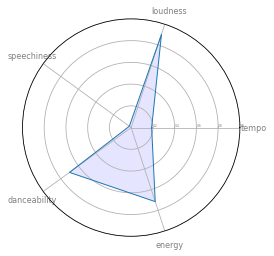

In [44]:
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, color='grey', size=8)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks( color="grey", size=3)
plt.ylim(0,1)
 
# Plot data
ax.plot(angles, values, linewidth=1, linestyle='solid')
 
# Fill area
ax.fill(angles, values, 'b', alpha=0.1)

# Show the graph
plt.show()

### Mood 
        plotting energy vs valence
        high energy, valence = happy
        low energy, valence = sad
        high energy, low valence = angsty
        low energy, high valence = chill

In [42]:
import plotly.graph_objects as go

fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=af.valence, y=af.energy,
                    mode='markers',
                    name='markers'))
fig.add_shape(type='line',
                x0=0,
                y0=0.5,
                x1=1,
                y1=0.5,
                line=dict(color='Red',),
                xref='x',
                yref='y'
)

fig.add_shape(type='line',
                x0=0.5,
                y0=0,
                x1=0.5,
                y1=1,
                line=dict(color='Red',),
                xref='x',
                yref='y'
)

fig.show() #hit songs have no chill

### Composition

Might make a graphic of the following below in PhotoShop

In [50]:
af['mode'].value_counts() #1 is major key, 0 is minor key

1    887
0    500
Name: mode, dtype: int64

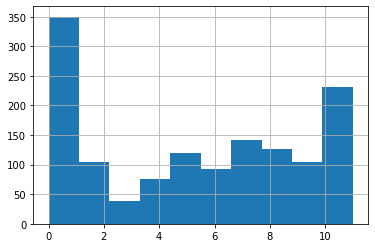

In [53]:
af.key.hist() # 0 is C, 11 is B

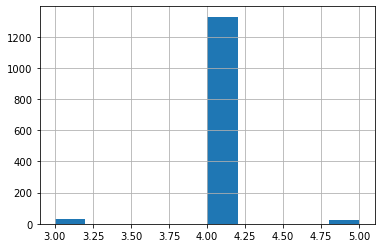

In [55]:
af.time_signature.hist() #okay it's almost always in 4/4 time

In [58]:
af.duration_ms.describe() #3.5 to 4 minutes is the sweet spot

count      1387.000000
mean     226931.108147
std       39016.111806
min       78200.000000
25%      203573.500000
50%      223190.000000
75%      243653.500000
max      688453.000000
Name: duration_ms, dtype: float64

In [76]:
ac = af[af.acousticness >= 0.7].sort_values(by='acousticness')#tried various cut off points and 0.7 seems to be the most accurate
len(ac)/len(af)*100 # only 2% are acoustic

2.235039653929344

In [83]:
ins = af[af.instrumentalness > 0.5].sort_values(by='instrumentalness') #it seems anything above 0.5 is mostly instrumental
len(ins)/len(af)*100 # only 0.4% are mostly instrumental

0.3604902667627974